## Setting up envrionment

### importing and installing modules

In [ ]:
# Install dependencies
!pip install -q --upgrade --no-cache-dir gdown
#!pip install -q plantcv

# Imports
import numpy as np
import os, json, cv2, random, gdown, zipfile, glob, math, shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from google.colab import files

# STCN
!git clone https://github.com/hkchengrex/STCN.git

# Download pretrained model
%cd STCN
!python download_model.py

%cd ..

Cloning into 'STCN'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 198 (delta 77), reused 63 (delta 63), pack-reused 78
Receiving objects: 100% (198/198), 101.61 KiB | 3.50 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/STCN
Downloading...
From: https://drive.google.com/uc?id=1mRrE0uCI2ktdWlUgapJI_KmgeIiF2eOm
To: /content/STCN/saves/stcn.pth
100% 218M/218M [00:14<00:00, 14.9MB/s]
Done.
/content


### Utility Functions

In [ ]:
def preprocess_data(source_dir, target_dir):
  os.makedirs(target_dir, exist_ok=True)
  for index, file_name in enumerate(sorted(os.listdir(source_dir))):
    file_src = os.path.join(source_dir, file_name)
    file_dest = os.path.join(target_dir,"{:05d}.jpg".format(index))

    shutil.copy(file_src, file_dest)

def move_files(source_dir, target_dir, file_names=None):
  if not file_names:
    file_names = os.listdir(source_dir)
      
  for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), os.path.join(target_dir, file_name))

def copy_files(source_dir, target_dir, file_names=None):
  if not file_names:
    file_names = os.listdir(source_dir)
      
  for file_name in file_names:
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(target_dir, file_name))

def delete_files_in_dir(source_dir, except_files=None):
  if not except_files:
    !rm -r $source_dir
    os.makedirs(source_dir, exist_ok=True)
  else:
    file_names = os.listdir(source_dir)
      
    for file_name in file_names:
      if file_name in except_files: continue
      os.remove(os.path.join(source_dir,file_name))

def is_empty(img_path):
  # detects if image is completely black
  image = cv2.imread(img_path)
  return cv2.countNonZero(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) == 0

def colour2binary(img):
  im_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  im_binary = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY)[1]
  return im_binary


### Download Komatsuna dataset

In [ ]:
# Create directories for evaluation
os.makedirs('STCN/test_data/Annotations/', exist_ok=True)
os.makedirs('STCN/test_data/JPEGImages/', exist_ok=True)
os.makedirs("STCN/test_data/output", exist_ok=True)
os.makedirs("STCN/test_data/Masks", exist_ok=True)

os.makedirs("PCV/JPEGImages", exist_ok=True)
os.makedirs("PCV/output", exist_ok=True)

In [ ]:
base_dir = "komatsuna"

if not os.path.isdir(base_dir):
  !gdown 1iOVAsyMU7NuBSdNOgbLP24kLi7rHtnZl
  !unzip -q komatsuna.zip

for dir in tqdm(sorted(os.listdir(base_dir))):
  annotation_dest = os.path.join("STCN/test_data/Annotations",dir)
  mask_dest = os.path.join("STCN/test_data/Masks",dir)
  mask_src = os.path.join(base_dir, dir, "mask")
  jpg_dest = os.path.join("STCN/test_data/JPEGImages",dir)
  jpg_src = os.path.join(base_dir, dir, "rgb")

  if os.path.isdir(annotation_dest):
    delete_files_in_dir(annotation_dest)
  else: os.makedirs(annotation_dest, exist_ok = True)
  if os.path.isdir(jpg_dest):
    delete_files_in_dir(jpg_dest)
  

  preprocess_data(jpg_src, jpg_dest)
  preprocess_data(mask_src, mask_dest)

  mask_first_path = os.path.join(mask_src, sorted(os.listdir(mask_src))[0])
  mask_first = cv2.imread(mask_first_path)
  mask_first_binary = colour2binary(mask_first)
  cv2.imwrite(os.path.join(annotation_dest, "00000.png"), mask_first_binary)
  #cv2.imwrite(os.path.join(annotation_dest, "00000.png"), mask_first)

  #For Plant CV
  jpg_dest = os.path.join("PCV/JPEGImages",dir)
  preprocess_data(jpg_src, jpg_dest)

Downloading...
From: https://drive.google.com/uc?id=1iOVAsyMU7NuBSdNOgbLP24kLi7rHtnZl
To: /content/komatsuna.zip
100% 9.65M/9.65M [00:00<00:00, 44.8MB/s]


100%|██████████| 5/5 [00:00<00:00, 32.10it/s]


## Classical CV

In [ ]:
from PIL import Image, ImageColor

def rgb2hsv(r, g, b):
  r, g, b = (r / 255, g / 255, b / 255)

  h, s, v = colorsys.rgb_to_hsv(r, g, b)
  h, s, v = (int(h * 179), int(s * 255), int(v * 255))

  return h, s, v


def hsv_threshold(img, low_hsv=np.array([25,52,72]), high_hsv=np.array([102,255,255])):
  hsv_frame=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  mask=cv2.inRange(hsv_frame,low_hsv ,high_hsv)
  return mask

def select_colour_bgr(img, b=255, g=255, r=255, thresh=10):
  low_b, low_g, low_r = max(0,b-thresh), max(0,g-thresh), max(0,r-thresh)
  high_b, high_g, high_r = min(255,b+thresh), min(255,g+thresh), min(255,r+thresh)
  high_bgr = np.array([high_b, high_g, high_r])
  low_bgr = np.array([low_b, low_g, low_r])
  mask = cv2.inRange(img, low_bgr, high_bgr)

  # Returns binary mask
  return mask

def select_colour_hsv(img, b=255, g=255, r=255, h_range=10, sv_range=50):
  h, s, v = rgb2hsv(r, g, b)

  high_h, high_s, high_v = min(179, h + h_range), min(255, s + sv_range), min(255, v + sv_range)
  low_h, low_s, low_v = max(0, h - h_range), max(0, s - sv_range), max(0, v - sv_range)
  high_hsv = np.array([high_h, high_s, high_v])
  low_hsv = np.array([low_h, low_s, low_v])
  mask = hsv_threshold(img, low_hsv, high_hsv)

  # Returns binary mask
  return mask

def medianblur(img):
  median = cv2.medianBlur(img,9)
  median = cv2.medianBlur(median,7)
  # returns bgr image
  return median

def remove_blobs(img, min_size=50):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(gray)
  sizes = stats[:, -1]
  sizes = sizes[1:]
  nb_blobs -= 1


  # output image with only the kept components
  im_result = np.zeros((img.shape))
  # for every component in the image, keep it only if it's above min_size
  for blob in range(nb_blobs):
      if sizes[blob] >= min_size:
          # see description of im_with_separated_blobs above
          im_result[im_with_separated_blobs == blob + 1] = 255

  mask = colour2binary(np.uint8(im_result))
  # Returns black/white mask with 3 channels
  return mask
  
def denoise(img):
  median = medianblur(img)
  mask = remove_blobs(median)
  result = cv2.bitwise_and(img,img,mask=mask)

  return result, mask

def custom_threshold(img, thresh=5):
  height, width, _ = img.shape
  green = np.zeros((img.shape), np.uint8)
  for h in range(height):
    for w in range(width):
      b, g, r = img[h, w]
      b, g ,r = int(b), int(g), int(r)
      if (g-thresh > b) and (g-thresh > r) and (abs(b-r)>thresh*2):
        green[h,w] = img[h,w]

  mask = colour2binary(green)
  # Returns bgr image and binary mask
  return green, mask

def filter_1(img):
  green, _ = custom_threshold(img)
  green, _ = denoise(green)

  return green

def segmentation_CV(input_dir, output_dir):
  os.makedirs(output_dir, exist_ok=True)
  for img_name in tqdm(sorted(os.listdir(input_dir))):
    src = os.path.join(input_dir, img_name)
    dest = os.path.join(output_dir, img_name.replace(".jpg",".png"))

    img = cv2.imread(src)
    
    result = filter_1(img)
    cv2.imwrite(dest, result)

In [ ]:
data_path = "PCV/JPEGImages"
for dir in os.listdir(data_path):
  jpg_src = os.path.join(data_path, dir)
  mask_dest = os.path.join("PCV/output", dir)

  segmentation_CV(jpg_src, mask_dest)


100%|██████████| 60/60 [00:04<00:00, 13.39it/s]


## STCN

In [ ]:
%cd STCN
!python eval_generic.py --data_path test_data --output test_data/output
%cd ..

/content/STCN
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100% 97.8M/97.8M [00:00<00:00, 171MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100% 44.7M/44.7M [00:00<00:00, 117MB/s]
Processing Bin_0 ..

## Mask-RCNN

In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -q -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -q -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .


!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

#download komatsuna dataset in coco format
!gdown 14n_BkExqo9VqV5oDG04DzAyJPawS0e-L
!unzip komatsuna_coco > /dev/null

import mmcv, mmdet
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector
import torch, torchvision
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

# Choose to use a config and initialize the detector
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 839.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 50.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.9.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.9.0+cu111 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 8.0 MB/s eta 0:00:00
Cloning into 'mmdetection'...
remote: Enumerating objects: 34936, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 34936 (delta 5), reused 9 (delta 2), pack-reused 34918
Receiving objects: 100% (34936/34936), 46.68 MiB | 27.22 MiB/s, done.

/usr/local/lib/python3.9/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


MaskRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_1x_coco.py')
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'COCODataset'

cfg.data.test.ann_file = 'dataset/images/test/labels.json'
cfg.data.test.img_prefix = ''
cfg.data.test.classes = ('plant',)

cfg.data.train.ann_file = 'dataset/images/train/labels.json'
cfg.data.train.img_prefix = ''
cfg.data.train.classes = ('plant',)


cfg.data.val.ann_file = 'dataset/images/val/labels.json'
cfg.data.val.img_prefix = ''
cfg.data.val.classes = ('plant',)

# modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

cfg.device="cuda"
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

def pred_rcnn(im_path):
  
  return mask

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


2023-03-20 13:06:11,070 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-03-20 13:06:11,088 - mmdet - INFO - load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2023-03-20 13:06:11,318 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits.bias

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 60/60, 8.5 task/s, elapsed: 7s, ETA:     0s

2023-03-20 13:15:11,593 - mmdet - INFO - Evaluating bbox...
2023-03-20 13:15:11,634 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.925
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.923
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.831
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.930
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.930
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.930
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.925
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.951
 Average R

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.02s).
Accumulating evaluation results...


/content/mmdetection/mmdet/datasets/coco.py:470: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
2023-03-20 13:15:11,681 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.808
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.791
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.827
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.827
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.827
 Ave

DONE (t=0.01s).


In [ ]:
os.makedirs("dataset/output/test",exist_ok=True)
model.cfg = cfg
for im_path in sorted(glob.glob("dataset/images/test/*.png")):
  mask_path = im_path.replace("images", "output").replace("rgb", "label")
  img = mmcv.imread(im_path)

  result = inference_detector(model, img)
  bbox_result, segm_result = result
  main_seg = segm_result[0][0]
  for seg in segm_result[0][1:]:
    continue
    main_seg = np.bitwise_or(main_seg, seg)
  
  mask = main_seg.astype(int)
  mask[np.where(main_seg[:]!=0)] = 255
  cv2.imwrite(mask_path, mask)

In [ ]:
%cd mmdetection

/content/mmdetection


In [ ]:
%cd ..

/content


## Generate video output

In [ ]:
# Converts output frames back into video
def frames2vid(main_dir, mask_dir, out_dir="video.mp4",fps=24):
  first_frame = cv2.imread(os.path.join(main_dir, "00000.jpg"))
  frame_size = (first_frame.shape[1], first_frame.shape[0])
  output = cv2.VideoWriter(out_dir, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

  for img in sorted(os.listdir(main_dir)):
    mask = cv2.resize(cv2.imread(os.path.join(mask_dir, img.replace("jpg","png"))), frame_size)
    mask_pixels = np.where(
          (mask[:, :, 0] != 0) | 
          (mask[:, :, 1] != 0) | 
          (mask[:, :, 2] != 0)
        )
    mask[mask_pixels] = [0,0,128]
    main = cv2.imread(os.path.join(main_dir, img))
    frame = cv2.addWeighted(main, 1, mask, 0.5, 0)
    
    output.write(frame)
    
  output.release()

# Converts output frames back into mask
def frames2mask(main_dir, mask_dir, out_dir="video.mp4",fps=24):
  first_frame = cv2.imread(os.path.join(main_dir, "00000.jpg"))
  frame_size = (first_frame.shape[1], first_frame.shape[0])
  output = cv2.VideoWriter(out_dir, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

  for img in sorted(os.listdir(main_dir)):
    main = cv2.imread(os.path.join(main_dir, img))
    mask = cv2.resize(cv2.imread(os.path.join(mask_dir, img.replace("jpg","png"))), frame_size)
    mask_pixels = np.where(
          (mask[:, :, 0] == 0) & 
          (mask[:, :, 1] == 0) & 
          (mask[:, :, 2] == 0)
        )
    main[mask_pixels] = [0,0,0]
    
    output.write(main)
    
  output.release()

def generate_videos(data_path, data_dest="output_videos", name=""):
  os.makedirs(data_dest, exist_ok=True)
  for dir in tqdm(sorted(os.listdir(os.path.join(data_path, "output")))):
    jpg_src = os.path.join(data_path,"JPEGImages", dir)
    mask_src = os.path.join(data_path, "output", dir)

    #mask_path = os.path.join(data_dest, dir+"{}_mask.mp4".format(name))
    #frames2mask(jpg_src, mask_src, out_dir=mask_path, fps=12)

    overlay_path = os.path.join(data_dest, dir+"{}_overlay.mp4".format(name))
    frames2vid(jpg_src, mask_src, out_dir=overlay_path, fps=12)

In [ ]:
generate_videos("STCN/test_data", name="_STCN")
generate_videos("PCV", name="_PCV")

100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


In [ ]:
dir = "output_videos"
for file_name in sorted(os.listdir(dir)):
  file_path = os.path.join(dir, file_name)
  files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate mask accuracy

In [ ]:
from sklearn.metrics import f1_score
import pandas as pd


def eval_F1_score(mask_true_path, mask_pred_path):
  mask_true = colour2binary(cv2.imread(mask_true_path)).flatten()
  mask_pred = colour2binary(cv2.imread(mask_pred_path)).flatten()
  score = f1_score(mask_true, mask_pred,average="binary", pos_label=0)
  return score


def F1_summary(mask_true = "STCN/test_data/Masks", mask_pred = "STCN/test_data/output"):
  df = pd.DataFrame()
  for dir_name in sorted(os.listdir(mask_pred)):
    mask_true_dir = os.path.join(mask_true, dir_name)
    mask_pred_dir = os.path.join(mask_pred, dir_name)
    mask_true_paths = [os.path.join(mask_true_dir, path) for path in sorted(os.listdir(mask_true_dir))]
    mask_pred_paths = [os.path.join(mask_pred_dir, path) for path in sorted(os.listdir(mask_pred_dir))]  
    scores = [eval_F1_score(mask_pair[0], mask_pair[1]) for mask_pair in zip(mask_true_paths, mask_pred_paths)]
    plt.plot([i for i in range(len(scores))],scores, label=dir_name)
    df[dir_name] = scores

  leg = plt.legend(loc='lower left')
  plt.xlabel("days")
  plt.ylabel("F-score")
  df["avg"] = df.mean(axis=1)
  return df

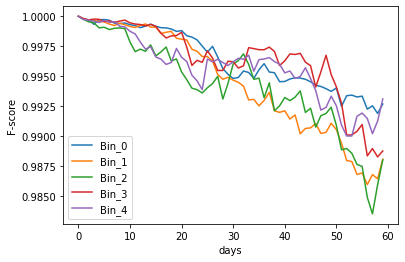

In [ ]:
df_STCN = F1_summary("STCN/test_data/Masks")

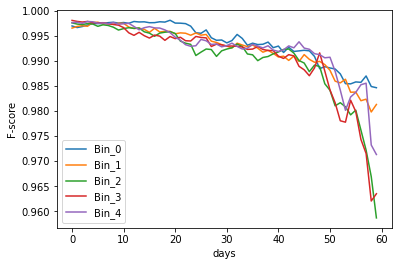

In [ ]:
df_PCV = F1_summary(mask_pred="PCV/output")

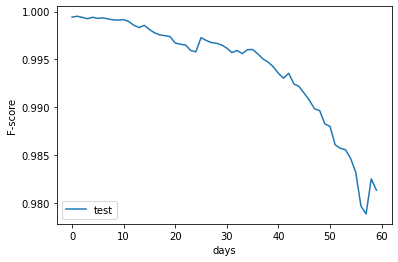

In [ ]:
df_RCNN = F1_summary(mask_true = "mmdetection/dataset/masks", mask_pred="mmdetection/dataset/output" )

Text(0, 0.5, 'F-score')

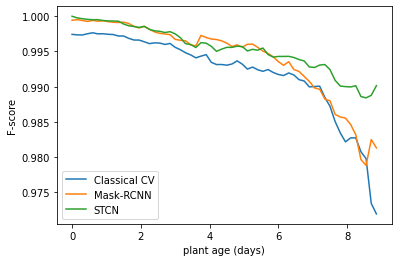

In [ ]:
days = [i*0.15 for i in range(60)]
plt.plot(days,df_PCV["avg"], label="Classical CV")
plt.plot(days,df_RCNN['avg'], label="Mask-RCNN")
plt.plot(days,df_STCN["avg"], label="STCN")


leg = plt.legend(loc='lower left')
plt.xlabel("plant age (days)")
plt.ylabel("F-score")

### Poster Display

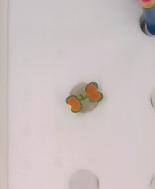

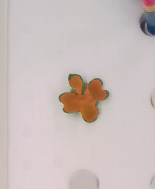

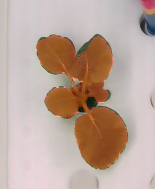

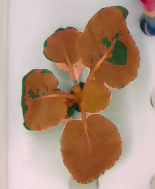

In [ ]:
mask_dir = "PCV/output/Bin_4"
main_dir = "PCV/JPEGImages/Bin_4"
for img in ["00005.jpg","00018.jpg","00048.jpg","00059.jpg"]:
  mask = cv2.imread(os.path.join(mask_dir, img.replace("jpg","png")))
  mask_pixels = np.where(
        (mask[:, :, 0] != 0) | 
        (mask[:, :, 1] != 0) | 
        (mask[:, :, 2] != 0)
      )
  mask[mask_pixels] = [0,0,180]
  main = cv2.imread(os.path.join(main_dir, img))
  frame = cv2.addWeighted(main, 1, mask, 0.5, 0)[:-30,5:-10]
  frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

  cv2_imshow(frame)

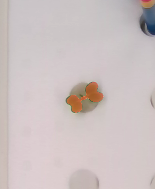

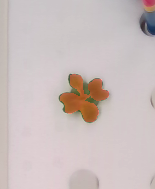

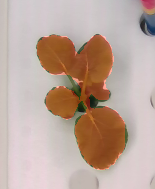

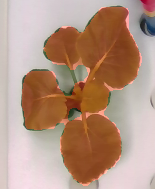

In [ ]:
mask_dir = "mmdetection/dataset/output/test"
main_dir = "mmdetection/dataset/images/test"
for img in ["label_04_000_05.png","label_04_003_00.png","label_04_008_00.png","label_04_009_05.png"]:
  mask = cv2.imread(os.path.join(mask_dir, img))
  mask_pixels = np.where(
        (mask[:, :, 0] != 0) | 
        (mask[:, :, 1] != 0) | 
        (mask[:, :, 2] != 0)
      )
  mask[mask_pixels] = [0,0,180]
  main = cv2.imread(os.path.join(main_dir, img.replace("label","rgb")))
  frame = cv2.addWeighted(main, 1, mask, 0.5, 0)[:-30,5:-10]
  frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

  cv2_imshow(frame)

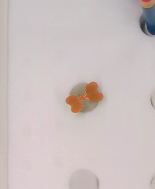

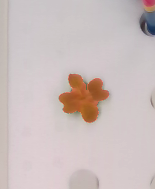

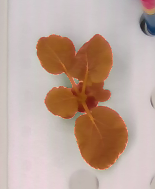

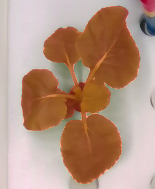

In [ ]:
mask_dir = "STCN/test_data/output/Bin_4"
main_dir = "STCN/test_data/JPEGImages/Bin_4"
for img in ["00005.jpg","00018.jpg","00048.jpg","00059.jpg"]:
  mask = cv2.imread(os.path.join(mask_dir, img.replace("jpg","png")))
  mask_pixels = np.where(
        (mask[:, :, 0] != 0) | 
        (mask[:, :, 1] != 0) | 
        (mask[:, :, 2] != 0)
      )
  mask[mask_pixels] = [0,0,180]
  main = cv2.imread(os.path.join(main_dir, img))
  frame = cv2.addWeighted(main, 1, mask, 0.5, 0)[:-30,5:-10]
  frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

  cv2_imshow(frame)